In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas
import numpy

In [2]:
def vocabulary_size(data, column="Global_CogID"):
    """Count different words in vocabulary."""
    return len(set(data[column]))

In [3]:
def semantic_width(data, column="Global_CogID"):
    """Calculate average synonym count.

    Calculate the average weighted semantic width in the language
    represented by data.

    """
    width = 0
    m = 0
    for form, meanings in data.groupby(column):
        width += meanings["Weight"].sum()**2/(meanings["Weight"]**2).sum()
        m += 1
    return width/m

In [4]:
def synonymity(data):
    """Calculate average synonym count.

    Calculate the average weighted synonym count in the language
    represented by data.

    """
    return semantic_width(data, column="Feature_ID")

In [5]:
clics_words = pandas.read_csv("/home/gereon/Downloads/words.csv")
clics_words["Weight"] = 1

clics_vocabulary = []
clics_semantic_width = []
clics_synonymity = []
for language, words in clics_words.groupby("LanguageId"):
    clics_vocabulary.append(vocabulary_size(words, "ClicsValue"))
    clics_semantic_width.append(semantic_width(words, "ClicsValue"))
    clics_synonymity.append(semantic_width(words, "ConcepticonGloss"))

In [6]:
path = "../"
steady_state = "Q"


Clics: 1317.4±805.2
Simulation: 875.5±27.5


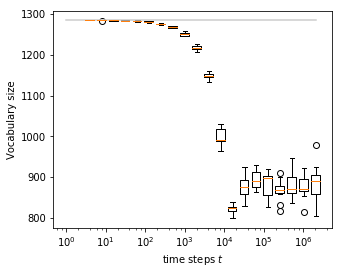

In [ ]:
import os
n = {}
for file in os.listdir(path):
    if file.startswith("trivial-long") and file.endswith(".tsv"):
        all_data = pandas.read_csv(
            os.path.join(path, file),
            sep="\t",
            na_values=[""],
            keep_default_na=False,
            encoding='utf-8')

        for language_id, language_data in all_data.groupby("Language_ID"):
            n.setdefault(2**(ord(language_id)-63), []).append(vocabulary_size(language_data))

plt.boxplot(list(n.values()), positions=list(n.keys()), widths=[i/2 for i in n.keys()], manage_xticks=False)

plt.plot([1, 2*1048576], [1284, 1284], '0.8', label="Root #Words")

plt.xlabel("time steps $t$")
plt.gca().set_xscale('log')
plt.ylabel("Vocabulary size")
print("Clics: {:0.1f}±{:0.1f}".format(
    numpy.mean(clics_vocabulary), numpy.std(clics_vocabulary)))
print("Simulation: {:0.1f}±{:0.1f}".format(numpy.mean(n[1048576]), numpy.std(n[1048576])))
plt.gcf().set_size_inches(5,4)
plt.savefig("vocabularysize_timesteps.pdf")

In [ ]:
import os
n = {}
p = {}
for file in os.listdir(path):
    if file.startswith("trivial-long-branch") and file.endswith(".tsv"):
        all_data = pandas.read_csv(
            os.path.join(path, file),
            sep="\t",
            na_values=[""],
            keep_default_na=False,
            encoding='utf-8')

        for language_id, language_data in all_data.groupby("Language_ID"):
            p.setdefault(2**(ord(language_id)-63), []).append(semantic_width(language_data))
            n.setdefault(2**(ord(language_id)-63), []).append(synonymity(language_data))

plt.boxplot(list(n.values()), positions=list(n.keys()), widths=[i/2 for i in n.keys()], manage_xticks=False)
plt.boxplot(list(p.values()), positions=list(p.keys()), widths=[i/2 for i in p.keys()], manage_xticks=False,
               boxprops=dict(color='blue'), medianprops=dict(color='red'))

plt.plot([1, 2*1048576], [1, 1], '0.8')

plt.plot([0,0],[1,1],c='red',label="Polysemy")
plt.plot([0,0],[1,1],c='orange',label="Synonymity")
plt.xlabel("time steps $t$")
plt.gca().set_xscale('log')
plt.ylabel("Average Polysemy/Synonymity")
plt.ylim((0, 5))
plt.legend()
print("Clics: {:0.1f}±{:0.1f}".format(
    numpy.mean(clics_vocabulary), numpy.std(clics_vocabulary)))
print("Simulation: {:0.1f}±{:0.1f}".format(numpy.mean(n[1048576]), numpy.std(n[1048576])))
plt.gcf().set_size_inches(5,4)
plt.savefig("synonymitypolysemy_timesteps.pdf")